In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy

In the following cell, we define the input folder and the zillo and demographics data scraped earlier using the scrapes using scrape_compile_demographics.py and the scrape_compile_zillow.py

In [2]:
INPUT_FOLDER = "data"

In [3]:
zillow = pd.read_csv(os.path.join(INPUT_FOLDER, "zillow.csv"))
dem = pd.read_csv(os.path.join(INPUT_FOLDER, "demographics.csv"))

## Zillow Dataset

All of the processing on the zillow data is done after scraping in the scrape_compile_zillow.py. In this notebook, we only load the zillow dataset saved in data folder by the aforementioned script

Please check the python file and the report for further information

In [4]:
zillow

,ZipCode,Price,Growth_YoY,1-Bedroom,2-Bedroom,3-Bedroom,4-Bedroom,5+ Bedroom,Condo-Co-op,Single-Family Homes
0,61639,718531,0,1,0,0,0,0,0,0
1,84654,220862,1,1,0,0,0,0,0,0
2,61637,837019,-2,1,0,0,0,0,0,0
3,84616,249230,0,1,0,0,0,0,0,0
4,91940,126214,4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
156450,60758,572182,5,0,0,0,0,0,0,1
156451,80874,167647,5,0,0,0,0,0,0,1
156452,58084,278189,1,0,0,0,0,0,0,1
156453,66169,1281711,8,0,0,0,0,0,0,1


## Demographics Dataset

Most of the processing on the zillow data is done after scraping in the scrape_compile_demographics.py. In this notebook, we only load the zillow dataset saved in data folder by the aforementioned script

Please check the python file and the report for further information

In [5]:
dem

,ZipCode,Income,Income Change,Population,Density,White Percentage
0,63045,65300.0,1.017440,998954.0,1162.35000,68.9
1,79772,58384.0,1.606550,13783.0,3.78197,19.5
2,62070,54392.0,1.086680,5089.0,10.79900,98.3
3,91615,64251.0,1.038720,9818605.0,1628.93000,27.8
4,80121,73925.0,1.129110,572003.0,422.95100,63.2
...,...,...,...,...,...,...
12195,70571,33288.0,0.938444,83384.0,67.08890,55.2
12196,77903,55631.0,1.023100,86793.0,75.72920,47.9
12197,90710,64251.0,1.038720,9818605.0,1628.93000,27.8
12198,79368,44975.0,1.021220,12651.0,9.91883,45.4


## Zipcodes

The zipcodes dataset is only used for the scraping and processing of the demogrpahic dataset. I do not use it directly in the following analysis

## Final Dataset (and some last minute cleanup)

Finally, I combine the two datasets. O also device the price by a 1000 to get Price (In thousands so we can get a bit smaller error values that are easier to read.)

In [6]:
df_final = zillow.merge(dem, how="inner")
df = df_final.drop(["ZipCode", "Growth_YoY"], axis=1)
df["Price"] = df["Price"]/1000.0
df

,Price,1-Bedroom,2-Bedroom,3-Bedroom,4-Bedroom,5+ Bedroom,Condo-Co-op,Single-Family Homes,Income,Income Change,Population,Density,White Percentage
0,718.531,1,0,0,0,0,0,0,62342.0,1.030980,135394.0,119.81400,95.0
1,1203.664,0,1,0,0,0,0,0,62342.0,1.030980,135394.0,119.81400,95.0
2,1904.912,0,0,1,0,0,0,0,62342.0,1.030980,135394.0,119.81400,95.0
3,3026.426,0,0,0,1,0,0,0,62342.0,1.030980,135394.0,119.81400,95.0
4,5055.853,0,0,0,0,1,0,0,62342.0,1.030980,135394.0,119.81400,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64621,324.913,0,0,0,0,0,0,1,61990.0,1.179610,16321.0,5.38286,94.1
64622,100.646,0,0,0,0,0,0,1,59426.0,1.156160,4139.0,1.70760,97.9
64623,29.302,0,0,0,0,0,0,1,62949.0,0.982826,86905.0,78.33850,73.7
64624,117.579,0,0,0,0,0,0,1,113776.0,1.191400,718451.0,958.36100,42.3


I check and delete the rows with missing values. It is only 1% of the data so I do not loose much of the dataset

In [7]:
print(df.isnull().sum())
df = df[df.isnull().sum(axis=1)==0]
print("")
print("After dropping rows with missing values")
print()
print(df.isnull().sum())

Price                    0
1-Bedroom                0
2-Bedroom                0
3-Bedroom                0
4-Bedroom                0
5+ Bedroom               0
Condo-Co-op              0
Single-Family Homes      0
Income                 657
Income Change          657
Population             524
Density                524
White Percentage       524
dtype: int64

After dropping rows with missing values

Price                  0
1-Bedroom              0
2-Bedroom              0
3-Bedroom              0
4-Bedroom              0
5+ Bedroom             0
Condo-Co-op            0
Single-Family Homes    0
Income                 0
Income Change          0
Population             0
Density                0
White Percentage       0
dtype: int64


In [8]:
df["White Percentage"] = df["White Percentage"]#/100.0
df = df.sample(frac=1).reset_index()
df = df[list(df.columns)[1:]]

<ipython-input-8-5f2f5f745f4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["White Percentage"] = df["White Percentage"]#/100.0


## Exploration

Our data looks as follows. In the multiple cells below, I do some data exploration to get a  feel of the dataset

In [9]:
df

,Price,1-Bedroom,2-Bedroom,3-Bedroom,4-Bedroom,5+ Bedroom,Condo-Co-op,Single-Family Homes,Income,Income Change,Population,Density,White Percentage
0,339.730,0,0,0,0,0,0,1,52097.0,1.019460,116672.0,25.54840,87.1
1,79.247,0,0,0,0,0,1,0,51930.0,1.028420,113237.0,114.73400,82.4
2,64.160,0,1,0,0,0,0,0,55550.0,0.970973,375770.0,49.18110,58.7
3,298.816,0,0,1,0,0,0,0,64478.0,0.870914,7359.0,3.51258,88.5
4,137.977,0,1,0,0,0,0,0,39412.0,1.077660,13982.0,17.62430,96.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63964,98.387,0,1,0,0,0,0,0,44058.0,0.979522,195751.0,24.97290,35.3
63965,123.788,1,0,0,0,0,0,0,46295.0,1.028440,2790.0,2.21282,93.1
63966,504.712,0,0,0,0,1,0,0,49142.0,1.079470,18728.0,4.52651,38.8
63967,194.873,0,0,0,0,1,0,0,64251.0,1.038720,9818605.0,1628.93000,27.8


I do a check and calulate the average prices for the ach of the house types. The data looks as we expected as the avg_prices increasing with the number of rule

In [10]:
columns = list(df.columns)
house_types = columns[1:8]

for house_type in house_types:
    avg_price = df[df[house_type]==1]["Price"].mean()
    print("Averge price of {}: {}".format(house_type, avg_price))

Averge price of 1-Bedroom: 166.96899012593073
Averge price of 2-Bedroom: 178.84274782442367
Averge price of 3-Bedroom: 233.06851811594134
Averge price of 4-Bedroom: 309.9402448140706
Averge price of 5+ Bedroom: 423.1989384508997
Averge price of Condo-Co-op: 243.61490084235862
Averge price of Single-Family Homes: 234.42968017791281


I plot each of the demographics data against the price one by one. It looks as expected

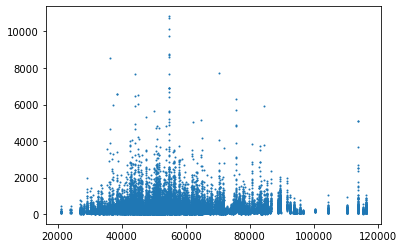

Price correlation with Income: 0.04681266570200474


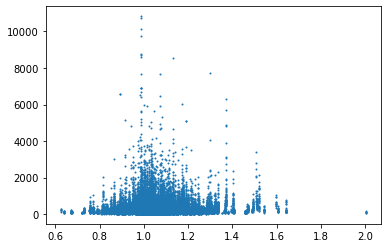

Price correlation with Income Change: 0.04031169992655204


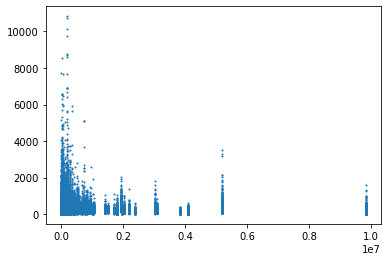

Price correlation with Population: -0.06451414984471028


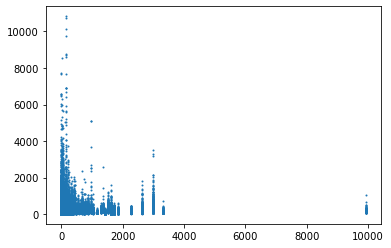

Price correlation with Density: -0.045312248799483146


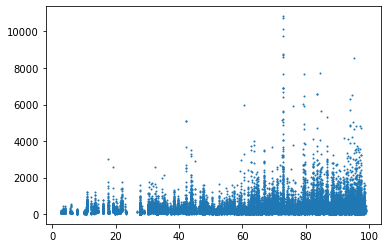

Price correlation with White Percentage: 0.10716186585351085




In [11]:
for col in ["Income", "Income Change", "Population", "Density", "White Percentage"]:
    plt.scatter(df[col], df["Price"], s=1)
    plt.show()

    correlation = df[["Price", col]].corr().values[1,0]
    print("Price correlation with {}: {}".format(col, correlation))
    
print()
print()

I plot the correlation matrix

Correlation Matrix: 


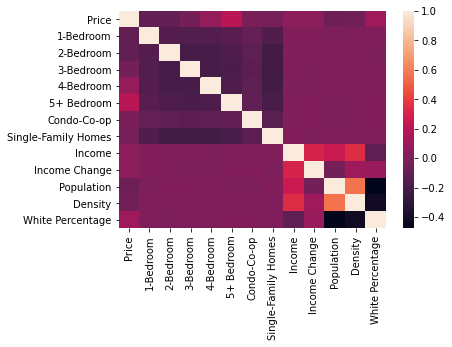

In [12]:
print("Correlation Matrix: ")
sns.heatmap(df.corr())

# Machine Learning

I divide the data into the X and Y matrices

In [13]:
X = df[columns[1:]].values
Y = df["Price"].values

### Baseline

A good baseline would be a model that predicts the average value every time

In [33]:
avg_price = df["Price"].median()
preds_baseline = np.ones(Y.shape) * avg_price
mse_baseline = mean_squared_error(Y.ravel(), preds_baseline)

print("Average Price: ", avg_price)
print("Baseline MSE: ", mse_baseline)

Average Price:  175.975
Baseline MSE:  111868.58737393416


I create a test and train set using a 90/10 split

In [15]:
perm = np.random.permutation(Y.shape[0])
split = int(Y.shape[0] * 0.9)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(57572, 12) (6397, 12) (57572,) (6397,)


In [16]:
df

,Price,1-Bedroom,2-Bedroom,3-Bedroom,4-Bedroom,5+ Bedroom,Condo-Co-op,Single-Family Homes,Income,Income Change,Population,Density,White Percentage
0,339.730,0,0,0,0,0,0,1,52097.0,1.019460,116672.0,25.54840,87.1
1,79.247,0,0,0,0,0,1,0,51930.0,1.028420,113237.0,114.73400,82.4
2,64.160,0,1,0,0,0,0,0,55550.0,0.970973,375770.0,49.18110,58.7
3,298.816,0,0,1,0,0,0,0,64478.0,0.870914,7359.0,3.51258,88.5
4,137.977,0,1,0,0,0,0,0,39412.0,1.077660,13982.0,17.62430,96.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63964,98.387,0,1,0,0,0,0,0,44058.0,0.979522,195751.0,24.97290,35.3
63965,123.788,1,0,0,0,0,0,0,46295.0,1.028440,2790.0,2.21282,93.1
63966,504.712,0,0,0,0,1,0,0,49142.0,1.079470,18728.0,4.52651,38.8
63967,194.873,0,0,0,0,1,0,0,64251.0,1.038720,9818605.0,1628.93000,27.8


## Linear Regression for Insights

I create and train a linear regression model and check the performance

In [17]:
lr = LinearRegression().fit(X_train, Y_train)
mse_train = mean_squared_error(Y_train.ravel(), lr.predict(X_train).ravel())
mse_test = mean_squared_error(Y_test, lr.predict(X_test))
print("Train SET MSE: ", mse_train)
print("Test Set MSE: ", mse_test)
print()
print('Linear Regression Coefficients:')
pd.DataFrame(lr.coef_.reshape(1, -1), columns=columns[1:]).loc[0]

Train SET MSE:  96424.93865717466
Test Set MSE:  106537.57322837455

Linear Regression Coefficients:


1-Bedroom              -88.441348
2-Bedroom              -76.394390
3-Bedroom              -23.079933
4-Bedroom               56.219564
5+ Bedroom             166.686468
Condo-Co-op            -13.540551
Single-Family Homes    -21.449809
Income                   0.001464
Income Change           39.658811
Population              -0.000004
Density                 -0.006713
White Percentage         1.303914
Name: 0, dtype: float64

In [18]:
Y_train

array([339.73 ,  79.247,  64.16 , ..., 201.219, 232.102, 223.821])

## Transformation (Scaling and PCA)

### PCA

In [19]:
pca = PCA().fit(X, Y)
print(pca.explained_variance_ratio_)

[9.99942568e-01 5.73296360e-05 1.01757165e-07 1.14427030e-10
 5.17247315e-14 4.85876717e-14 4.62864161e-14 4.02572705e-14
 3.26669714e-14 1.99595584e-14 1.99566752e-15 2.24216302e-41]


In [20]:
n_features = 5
X_train_PCA = pca.transform(X_train)[:, :n_features]
X_test_PCA = pca.transform(X_test)[:, :n_features]

lr = LinearRegression().fit( X_train_PCA, Y_train)
mse_train = mean_squared_error(Y_train, lr.predict(X_train_PCA) )
mse_test = mean_squared_error(Y_test, lr.predict(X_test_PCA))
print("Train SET MSE: ", mse_train)
print("Test Set MSE: ", mse_test)

Train SET MSE:  102690.9332596249
Test Set MSE:  112908.24909851889


### Standard Scaler

In [21]:
s_scaler = StandardScaler().fit(X)
X_train_s_scaled = s_scaler.transform(X_train)
X_test_s_scaled = s_scaler.transform(X_test)

lr = LinearRegression().fit( X_train_s_scaled, Y_train)
mse_train = mean_squared_error(Y_train, lr.predict(X_train_s_scaled) )
mse_test = mean_squared_error(Y_test, lr.predict(X_test_s_scaled))
print("Train SET MSE: ", mse_train)
print("Test Set MSE: ", mse_test)

Train SET MSE:  96425.13881915661
Test Set MSE:  106538.08186387901


### MinMaxScaler

In [22]:
m_scaler = MinMaxScaler().fit(X)
X_train_m_scaled = m_scaler.transform(X_train)
X_test_m_scaled = m_scaler.transform(X_test)

lr = LinearRegression().fit( X_train_m_scaled, Y_train)
mse_train = mean_squared_error(Y_train, lr.predict(X_train_m_scaled) )
mse_test = mean_squared_error(Y_test, lr.predict(X_test_m_scaled))
print("Train SET MSE: ", mse_train)
print("Test Set MSE: ", mse_test)

Train SET MSE:  96425.07792077029
Test Set MSE:  106537.31245979962


## More Complicated Algorithms

The following functions are used to suppor the testing for applying the algorithms that follow.

ScalerPcaTransform takes the X matrix, a scaler (MinMax or Standard) as well as a bool pca deciding if pca should be applie dor not

ExpeirmentModel on the other hand accepts and X and Y arguments for my data and takes a custom function defined below for every deifferent algorithm and a list called configs with all the configs to test, agian generated using a custom function for every algorith. It loops over the configs and run the model_func custom function that is different for every algorithm

In [23]:
def ScalerPcaTransfrom(X, scaler, pca):
    X_c = deepcopy(X)
    if(scaler!=None):
        scaler = scaler().fit(X_c)
        X_c = scaler.transform(X_c)
    if(pca):
        pca = PCA().fit(X_c)
        X_c = pca.transform(X_c)
        
    return X_c

def ExperimentModels(X, Y, model_func, configs):
    
    i=-1
    j=-1
    means = []
    variances = []
    #fig, ax = plt.subplots()
    for config in configs:
        j=j+1
        mean, variance = model_func(X, Y, config, scaler = config["scaler"], pca=config["pca"])
        means.append(means)
        variances.append(variance)
        configs.append(config)
            
    return means, variances, configs

## Random Forests

In [31]:
def GetRFConfigs():

    values_to_test = {"n_estimators": [10, 100, 500], 
                      "max_depth": [None, 6, 3], 
                      "min_samples_split" : [2, 4], 
                      "min_samples_leaf" : [1, 3], 
                      "scaler" : [None, StandardScaler, MinMaxScaler],
                      "pca" : [False, True]}
    configs = []
    
    for scaler in values_to_test["scaler"]:
        for pca in values_to_test["pca"]:
            for n_e in values_to_test["n_estimators"]:
                for max_depth in values_to_test["max_depth"]:
                    for min_ss in values_to_test["min_samples_split"]:
                        for min_sl in values_to_test["min_samples_leaf"]:
                            config = {"n_estimators": n_e, 
                                      "max_depth": max_depth, 
                                      "min_samples_split" : min_ss, 
                                      "min_samples_leaf" : min_sl,
                                      "scaler" : scaler,
                                      "pca" : pca}
                            configs.append(config)
    return configs

    


def RunRFModel(X, y, config, scaler=None, pca=False):
    #print(config)
    #X_c = ScalerPcaTransfrom(X, scaler, pca)
    reg = RandomForestRegressor(n_estimators = config["n_estimators"],
                                max_depth = config["max_depth"],
                                min_samples_split = config["min_samples_split"],
                                min_samples_leaf = config["min_samples_leaf"])
    scores = cross_val_score(reg, X, y, cv=3, scoring="neg_mean_squared_error") * -1
    mean = scores.min()
    variance = scores.var()
    return mean, variance

In [36]:
configs_to_test = GetRFConfigs()
means, variances, configs = ExperimentModels(X, Y, RunRFModel, configs_to_test)

KeyboardInterrupt: 

I get the configuration with the lowest error metric

In [38]:
best_config = configs[np.argmin(means).ravel()]

{'n_estimators': 100,
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'scaler': None,
 'pca': False}

In [28]:
config = best_config
reg = RandomForestRegressor(n_estimators = best_config["n_estimators"],
                            max_depth = base_config["max_depth"],
                            min_samples_split = base_config["min_samples_split"],
                            min_samples_leaf = base_config["min_samples_leaf"])
#reg.fit(X, Y)
scores = cross_val_score(reg, X, Y, scoring="neg_mean_squared_error") * -1

In [35]:
config = configs_to_test[0]
reg = RandomForestRegressor(n_estimators = config["n_estimators"],
                            max_depth = config["max_depth"],
                            min_samples_split = config["min_samples_split"],
                            min_samples_leaf = config["min_samples_leaf"])
#reg.fit(X, Y)
scores = cross_val_score(reg, X, Y, scoring="neg_mean_squared_error") * -1
mse_rf = np.mean(scores)
print("Random forest MSE (CrossVal):", mse_rf)

Random forest MSE (CrossVal): 59164.66568705057
